In [ ]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
  Using cached pandasgui-0.2.15-py3-none-any.whl
  Using cached PyQtWebEngine-5.15.7-cp38-abi3-manylinux_2_17_x86_64.whl.metadata (1.8 kB)
  Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached qtstylish-0.1.5-py3-none-any.whl
Using cached PyQtWebEngine-5.15.7-cp38-abi3-manylinux_2_17_x86_64.whl (227 kB)
Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (547 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandasgui]/4 [pandasgui]
Note: you may need to restart the kernel to use updated packages.


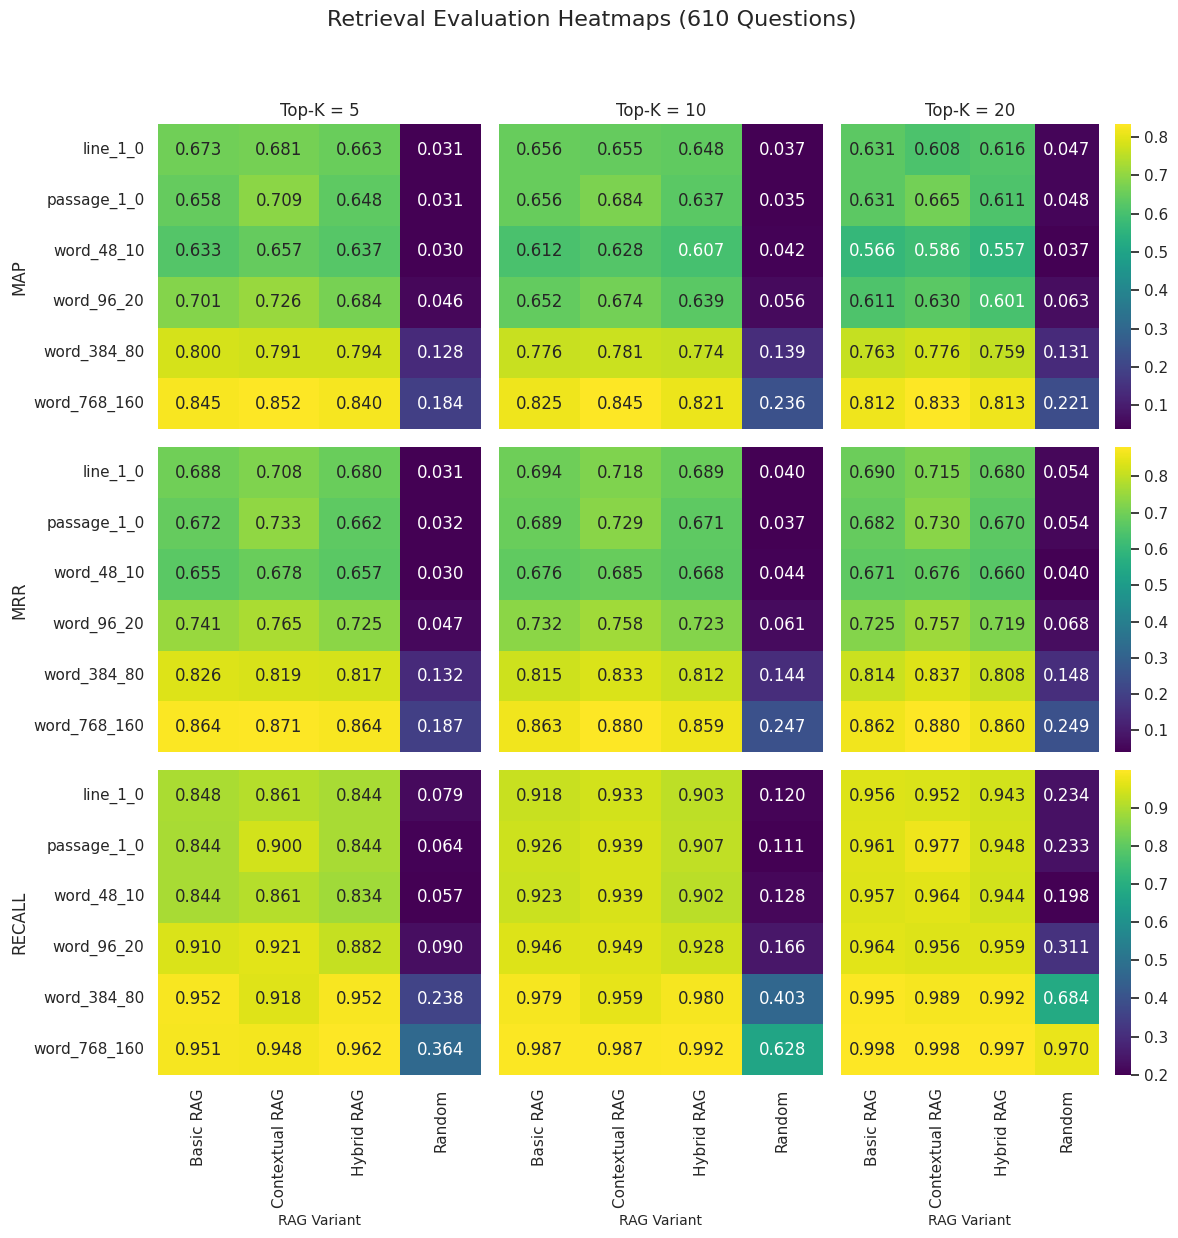

In [8]:
import os
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ─── CONFIG ────────────────────────────────────────────────────────────────────
BASE_DIR        = "results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B"
PATTERN         = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")
METRICS         = ["map", "mrr", "recall"]
CMAP            = "viridis"

# ← Define your exact splitting‐row order here: ←
SPLITTING_ORDER = [
    "line_1_0",
    "passage_1_0",
    "word_48_10",
    "word_96_20",
    "word_384_80",
    "word_768_160",
]
# ─── END CONFIG ────────────────────────────────────────────────────────────────

# 1) Gather all records
records = []
for fp in glob.glob(PATTERN):
    splitting = os.path.basename(os.path.dirname(fp)).removeprefix("docs_")
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    if not m:
        continue
    topk = int(m.group(1))
    df   = pd.read_pickle(fp)

    # detect which prefixes have all three metrics
    prefixes = {
        col.rsplit("_",1)[0]
        for col in df.columns
        if any(col.endswith(f"_{m}") for m in METRICS)
    }
    prefixes = sorted(p for p in prefixes
                      if all(f"{p}_{metric}" in df.columns for metric in METRICS))

    def mean_col(s: pd.Series) -> float:
        clean = (
            s.dropna()
             .apply(lambda x: x[0] if isinstance(x,(list,tuple)) and len(x)==1 else x)
             .astype(float)
        )
        return clean.mean()

    for p in prefixes:
        for metric in METRICS:
            col = f"{p}_{metric}"
            records.append({
                "splitting": splitting,
                "topk"     : topk,
                "rag_type" : p,
                "metric"   : metric,
                "score"    : mean_col(df[col]) if col in df.columns else None
            })

results = pd.DataFrame(records)

# 2) Determine unique Top-K values
topks = sorted(results["topk"].unique())
rag_types = sorted(results["rag_type"].unique())

# 3) Enforce your splitting‐order (dropping any missing ones)
splittings = [s for s in SPLITTING_ORDER if s in results["splitting"].unique()]

# 4) Plot grid of heatmaps: rows=metrics, cols=topk
sns.set(style="whitegrid")
fig, axes = plt.subplots(
    nrows=len(METRICS),
    ncols=len(topks),
    figsize=(4 * len(topks), 4 * len(METRICS)),
    sharex="col",
    sharey="row"
)
axes = np.atleast_2d(axes)

for i, metric in enumerate(METRICS):
    for j, tk in enumerate(topks):
        ax = axes[i, j]
        sub = results[(results.metric == metric) & (results.topk == tk)]

        # pivot then reindex rows in your desired order
        pivot = sub.pivot_table(
            index="splitting",
            columns="rag_type",
            values="score",
            aggfunc="mean"
        ).reindex(index=splittings, columns=rag_types)

        if pivot.empty or pivot.isna().all().all():
            ax.axis("off")
            continue

        sns.heatmap(
            pivot,
            annot=True,
            fmt=".3f",
            cmap=CMAP,
            cbar=(j == len(topks)-1),
            ax=ax
        )
        if i == 0:
            ax.set_title(f"Top-K = {tk}", fontsize=12)
        if j == 0:
            ax.set_ylabel(metric.upper(), fontsize=12)
        else:
            ax.set_ylabel("")
        if i == len(METRICS)-1:
            ax.set_xlabel("RAG Variant", fontsize=10)
        else:
            ax.set_xlabel("")

first_fp = next(iter(glob.glob(PATTERN)), None)
row_count = None
if first_fp:
    try:
        first_df = pd.read_pickle(first_fp)

        # Get all prefixes that have all metric columns
        prefixes = {
            col.rsplit("_", 1)[0]
            for col in first_df.columns
            if all(f"{col.rsplit('_', 1)[0]}_{metric}" in first_df.columns for metric in METRICS)
        }

        # Build full set of metric column names
        metric_cols = [
            f"{prefix}_{metric}"
            for prefix in prefixes
            for metric in METRICS
        ]

        # Drop rows where *any* of those columns are NaN
        row_count = first_df.dropna(subset=metric_cols).shape[0]

    except Exception as e:
        print(f"Warning: Could not load or process {first_fp}: {e}")
if row_count is not None:
    fig.suptitle(f"Retrieval Evaluation Heatmaps ({row_count} Questions)", fontsize=16, y=1.03)
    
plt.tight_layout()
plt.show()

In [18]:
import glob
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = "results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B"
PATTERN = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")

all_dfs = []

for fp in glob.glob(PATTERN):
    print(f"Processing: {fp}")
    df = pd.read_pickle(fp)
    print("  Columns:", list(df.columns))
    
    # Find Contextual RAG columns
    contextual_cols = [col for col in df.columns if col.startswith("Basic RAG_")]
    print("  Contextual cols:", contextual_cols)
    
    if not contextual_cols:
        print("  Skipping because no contextual columns found.")
        continue
    
    if "variant" not in df.columns:
        print("  Skipping because 'variant' column not found.")
        continue
    
    # Extract Top-K from file name
    m = re.search(r"topk_(\d+)\.pkl$", fp)
    topk = int(m.group(1)) if m else None
    
    sub_df = df[contextual_cols + ["variant"]].copy()
    sub_df["source_file"] = os.path.basename(fp)
    sub_df["topk"] = topk
    all_dfs.append(sub_df)

print(f"\n✅ Loaded {len(all_dfs)} DataFrames.")

if not all_dfs:
    print("❌ No data loaded. Check your patterns or column names.")
else:
    contextual_data = pd.concat(all_dfs, ignore_index=True)
    print(f"✅ contextual_data shape: {contextual_data.shape}")

    # Melt into long format
    melted = contextual_data.melt(
        id_vars=["variant", "source_file", "topk"],
        var_name="metric",
        value_name="score"
    )

    # Clean metric names
    melted["metric"] = melted["metric"].str.replace("Contextual RAG_", "")
    
    melted = melted.dropna(subset=["score"])
    print(melted.head())

Processing: results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B/docs_word_768_160/topk_20.pkl
  Columns: ['question', 'references', 'groundTruth', 'source_file', 'documents', 'variant', 'prev_messages', 'Random_map', 'Random_mrr', 'Random_recall', 'Basic RAG_map', 'Basic RAG_mrr', 'Basic RAG_recall', 'Hybrid RAG_map', 'Hybrid RAG_mrr', 'Hybrid RAG_recall', 'Contextual RAG_map', 'Contextual RAG_mrr', 'Contextual RAG_recall']
  Contextual cols: ['Basic RAG_map', 'Basic RAG_mrr', 'Basic RAG_recall']
Processing: results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B/docs_word_768_160/topk_5.pkl
  Columns: ['question', 'references', 'groundTruth', 'source_file', 'documents', 'variant', 'prev_messages', 'Random_map', 'Random_mrr', 'Random_recall', 'Basic RAG_map', 'Basic RAG_mrr', 'Basic RAG_recall', 'Hybrid RAG_map', 'Hybrid RAG_mrr', 'Hybrid RAG_recall', 'Contextual RAG_map', 'Contextual RAG_mrr', 'Contextual RAG_recall']
  Contextual cols: ['Basic RAG_map', 'Basic RAG_mrr',

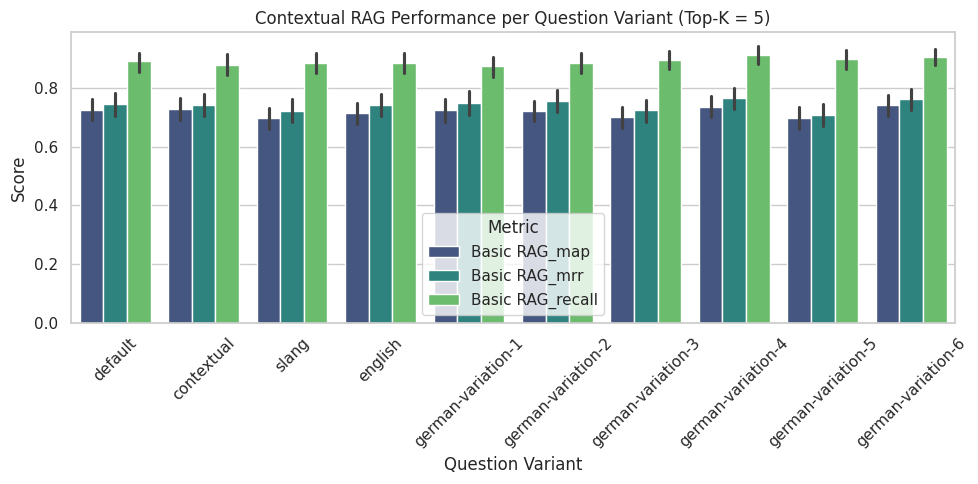

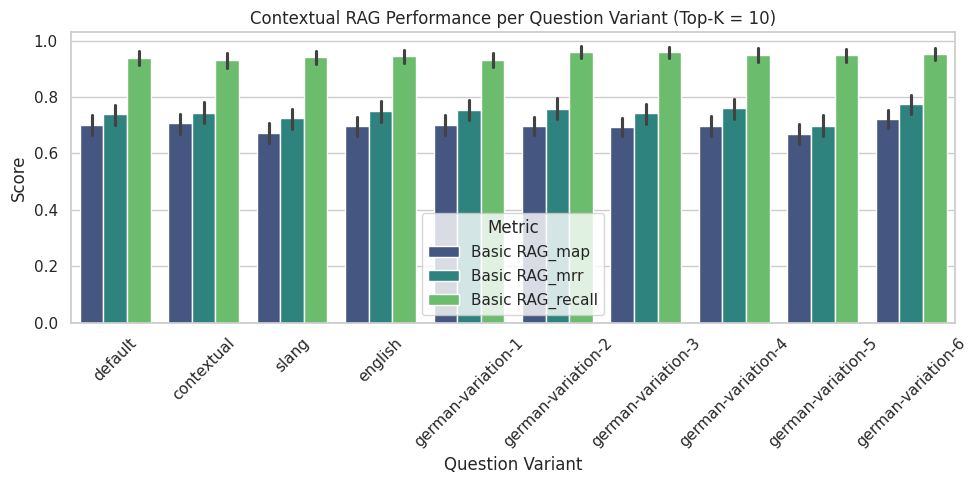

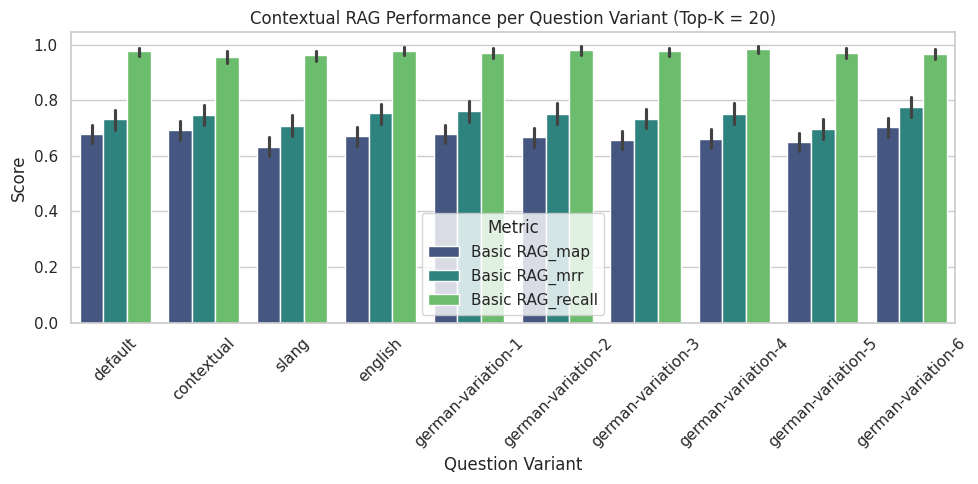

In [19]:
for tk in sorted(melted["topk"].unique()):
    subset = melted[melted["topk"] == tk]

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=subset,
        x="variant",
        y="score",
        hue="metric",
        estimator="mean",
        errorbar="ci",
        palette="viridis"
    )
    plt.title(f"Contextual RAG Performance per Question Variant (Top-K = {tk})")
    plt.ylabel("Score")
    plt.xlabel("Question Variant")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()

In [20]:
import glob
import os
import pandas as pd
import re

BASE_DIR = "results/retrieval/2025-06-27_14-16-40/QwenQwen3-Embedding-4B"
PATTERN = os.path.join(BASE_DIR, "docs_*", "topk_*.pkl")

contextual_questions = []

for fp in glob.glob(PATTERN):
    df = pd.read_pickle(fp)

    if "variant" not in df.columns:
        continue
    
    if "question" not in df.columns:
        continue

    # Filter only contextual rows
    sub_df = df[df["variant"] == "contextual"]

    if not sub_df.empty:
        # Optionally track the file the questions came from
        for q in sub_df["question"]:
            contextual_questions.append({
                "source_file": os.path.basename(fp),
                "question": q
            })

# Convert to DataFrame for pretty printing (optional)
contextual_df = pd.DataFrame(contextual_questions)

if contextual_df.empty:
    print("No contextual questions found.")
else:
    # Print all contextual questions
    print("✅ Contextual Questions:\n")
    for idx, row in contextual_df.iterrows():
        print(f"- ({row['source_file']}) {row['question']}")

✅ Contextual Questions:

- (topk_20.pkl) Und wie lange dauert dieser Eingriff normalerweise?
- (topk_20.pkl) Ja, der Arzt hat gesagt, das Baby liegt in Beckenendlage. Kann man die Wendung dann sofort versuchen oder muss ich noch warten?
- (topk_20.pkl) Könnte so ein Risiko auch bedeuten, dass dann ein Kaiserschnitt notwendig wird?
- (topk_20.pkl) Sind diese Methoden denn sicher und werden sie oft in Krankenhäusern angewendet?
- (topk_20.pkl) Und wie erkennt man genau, ob solche Komplikationen vorliegen?
- (topk_20.pkl) Beeinflussen bestimmte Risikofaktoren die Erfolgschancen bei meinem Fall?
- (topk_20.pkl) Gibt es Möglichkeiten, die Schmerzen während der Wendung zu verringern?
- (topk_20.pkl) Wird dann sofort ein Kaiserschnitt gemacht oder gibt es noch andere Möglichkeiten?
- (topk_20.pkl) Gibt es dann besondere Risiken für mein Baby bei der Wendung?
- (topk_20.pkl) Ja, der Eingriff ist morgen früh, ab wann darf ich nichts mehr zu mir nehmen?
- (topk_20.pkl) Können diese Atemprobleme 